In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import time
import math
import random
import copy
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import datasets, layers, models
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.utils.np_utils import to_categorical
from sklearn.cluster import KMeans, AgglomerativeClustering
from tensorflow.keras.datasets import cifar10 
#from keras.datasets import fashion_mnist 
#from sklearn.metrics import silhouette_samples, silhouette_score

mod = sys.modules[__name__]

In [2]:
def distribution_check(dataset):
        #분포가 다름;
    one,two,three,four,five,six,seven,eight,nine,ten=0,0,0,0,0,0,0,0,0,0

    for i in range(len(dataset)):
        if(dataset[i]==1):    one+=1
        elif(dataset[i]==2):  two+=1
        elif(dataset[i]==3):  three+=1
        elif(dataset[i]==4):  four+=1
        elif(dataset[i]==5):  five+=1
        elif(dataset[i]==6):  six+=1
        elif(dataset[i]==7):  seven+=1
        elif(dataset[i]==8):  eight+=1
        elif(dataset[i]==9):  nine+=1
        elif(dataset[i]==0):  ten+=1

    #print(one,two,three,four,five,six,seven,eight,nine,ten)
    #print("Sum : ", one+two+three+four+five+six+seven+eight+nine+ten)
    sums = one+two+three+four+five+six+seven+eight+nine+ten
    for_graph=[one,two,three,four,five,six,seven,eight,nine,ten]
    
    return for_graph, sums

def local_model_generate(model): #초기 모델 생성
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    
    return model

def step_function(data):
    if data > 0:
        return 1
    else:
        return 0

def sigmoid(data):
    return 1/(1+np.exp(-data))

def relu(data):
    return np.maximum(0,data)

def random_check(local, train_data, test_data):
    check_distribution_train_data, check_distribution_test_data, y_train_tmp, y_test_tmp = [], [], [], []
    sum1, sum2, data_index = 0,0, np.arange(0,10)

    for j in range(len(train_data)):
        y_train_tmp.append(np.argmax(train_data[j])) #원핫인코딩에서 다시 0~9 레이블로 변환

    for j in range(len(test_data)):
        y_test_tmp.append(np.argmax(test_data[j]))

    check_distribution_train_data, sum_train = distribution_check(y_train_tmp) #한번 밖에 실행 못함
    check_distribution_test_data, sum_test = distribution_check(y_test_tmp)
    sum1, sum2 = (sum1 + sum_train), (sum2 + sum_test)
    
    return check_distribution_train_data, check_distribution_test_data


In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape, x_test.shape)
num_train, num_test = len(x_train),  len(x_test) 

(50000, 32, 32, 3) (10000, 32, 32, 3)


In [4]:
local = 21 # 10개 : 1~10 => 11은 포함 안됨
batch_size, epochs = 32, 5
global_epoch = 0
num_layers = 8

In [5]:
# Model / data parameters
num_classes = 10
input_shape = (32, 32, 3)

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

print("Step 1 x_train shape:", x_train.shape)

#x_train = x_train.reshape((num_train, 28, 28, 1))
#x_test = x_test.reshape((num_test, 28, 28, 1))

print("Step 2 x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")
# convert class vectors to binary class matrices => one hot encoding 지금은 [3,6,2,5,4,8..] 섞여있음 

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Step 1 x_train shape: (50000, 32, 32, 3)
Step 2 x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [6]:
global_epoch = 0

print(global_epoch, " 번째 global_epoch 데이터 랜덤하게 준비!!")

for i in range(1,local): #데이터 변수 선언, 빈 리스트로 초기화
    globals()['L{}_x_train'.format(i)], globals()['L{}_x_test'.format(i)] = [],[]  
    globals()['L{}_y_train'.format(i)], globals()['L{}_y_test'.format(i)] = [],[]  


for n in range(1,local): #x_train_range, 잘 작동함 => 확인 완료

    x_train_range = list(np.arange(0,len(x_train)))  #0~59,999
    x_test_range = list(np.arange(0,len(x_test)))  #0~9,999

    tmp, tmp2 = [], []

    num_pick = random.randint(1000, 5000) #변동 사항 #int(len(list(x_train_range))/local)
    num_pick2 = int(len(x_test_range)/local) #test 데이터는 원래대로 항상 일정한 비율로 주면 될듯 => 어느정도 분량 이상 있어야 함
    
    tmp = random.sample(list(x_train_range), num_pick)  #1/10개 만큼 인덱스 랜덤 비복원 추출 => 랜덤으로 해야함
    tmp2 = random.sample(list(x_test_range), num_pick2)

    for i in range(len(tmp)):
        globals()['L{}_x_train'.format(n)].append(x_train[tmp[i]])  #n번째 Cluster에 분할한 실제 x_train 데이터 저장
        globals()['L{}_y_train'.format(n)].append(y_train[tmp[i]]) 
        #x_train_range.remove(tmp[i])  #랜덤 하게 뽑힌 원소갯수들 추출했으니 안에서 삭제  => 오래걸림

    for j in range(len(tmp2)):
        globals()['L{}_x_test'.format(n)].append(x_test[tmp2[j]])
        globals()['L{}_y_test'.format(n)].append(y_test[tmp2[j]])
        #x_test_range.remove(tmp2[j])  #랜덤 하게 뽑힌 원소 1000개 추출했으니 안에서 삭제  => 오래걸림
    
    print("CHECK :", n," 번째 로컬 클라이언트 Number of Training sets : ", len(globals()['L{}_x_train'.format(n)]), "   Number of Training sets : ", len(globals()['L{}_x_test'.format(n)]))

print("check=>: should be 0 == ", len(x_train_range))  #원소 하나도 없어야 함. 확인.
print(global_epoch, " 번째 global_epoch 데이터 랜덤 준비완료!!")

0  번째 global_epoch 데이터 랜덤하게 준비!!
CHECK : 1  번째 로컬 클라이언트 Number of Training sets :  2857    Number of Training sets :  476
CHECK : 2  번째 로컬 클라이언트 Number of Training sets :  3557    Number of Training sets :  476
CHECK : 3  번째 로컬 클라이언트 Number of Training sets :  1746    Number of Training sets :  476
CHECK : 4  번째 로컬 클라이언트 Number of Training sets :  2863    Number of Training sets :  476
CHECK : 5  번째 로컬 클라이언트 Number of Training sets :  1824    Number of Training sets :  476
CHECK : 6  번째 로컬 클라이언트 Number of Training sets :  2892    Number of Training sets :  476
CHECK : 7  번째 로컬 클라이언트 Number of Training sets :  1747    Number of Training sets :  476
CHECK : 8  번째 로컬 클라이언트 Number of Training sets :  2008    Number of Training sets :  476
CHECK : 9  번째 로컬 클라이언트 Number of Training sets :  2990    Number of Training sets :  476
CHECK : 10  번째 로컬 클라이언트 Number of Training sets :  2835    Number of Training sets :  476
CHECK : 11  번째 로컬 클라이언트 Number of Training sets :  4686    Number of Trainin

In [7]:
#준비된 데이터 (IID / NON-IID) np.array로

local = 21

global_epoch = 0
FedAvg_ACC, FedAvg_LOSS, fedavg_acc, fedavg_loss, acc, loss = [], [], [], [], 0, 0
num_layers_list = [0,2,4,6,7]
label_list = []

VAR_final_list_w, VAR_final_list_b = [], []


for i in range(1,local):
    globals()['L{}_x_train'.format(i)] = np.array(globals()['L{}_x_train'.format(i)])
    globals()['L{}_x_test'.format(i)] = np.array(globals()['L{}_x_test'.format(i)])
    globals()['L{}_y_train'.format(i)] = np.array(globals()['L{}_y_train'.format(i)])
    globals()['L{}_y_test'.format(i)] = np.array(globals()['L{}_y_test'.format(i)])


print("\n\n",global_epoch, "번째 global epoch에서 로컬 클라이언트 학습시작!\n\n학습 중 ...\n")
now = time.time()

for i in range(1,local):
    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)] = models.Sequential()  ##!!!!!!! 이게 글로벌 epoch에서는 2번째 부터 들어가면 안됨
    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)] = local_model_generate(globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)])      # initialize 필요 => 모델 프레임 구축

    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].fit(globals()['L{}_x_train'.format(i)], globals()['L{}_y_train'.format(i)], batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)

    loss, acc = globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].evaluate(globals()['L{}_x_test'.format(i,global_epoch)], globals()['L{}_y_test'.format(i)], verbose=2)
    
    fedavg_acc.append(acc)  #acc 넣기
    fedavg_loss.append(loss)  #loss 넣기


print(global_epoch, "번째 global epoch 로컬 클라이언트 학습완료!,  Total Training time : ", time.time()-now,"\n\n")

# 로컬 모델들 학습 완료하였고 로컬모델에서 weight, bias 추출 -------------------------------------------------------------------------------------

for i in range(1, local):
    for layer_index in num_layers_list:
        w = globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].layers[layer_index].get_weights() #get_weights = w[0],b[1]로 구성

        globals()['L{}_layer{}_w_tmp'.format(i,layer_index)] = w      # 클러스터링 용도
        globals()['L{}_layer{}_w'.format(i,layer_index)] = w          # weight aggregation 용도
            

for layer_index in num_layers_list:

    globals()['layer{}_W_tmp'.format(layer_index)] = []
    globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = 0  #FedAvg 용도
    
    globals()['var_list_layer{}_w'.format(layer_index)] = []
    globals()['var_list_layer{}_b'.format(layer_index)] = []
  
    w_scaler = 0
    #------------------------------------------------FedAvg--------------------------------------------------------
    for i in range(1, local):
        globals()['var_list_layer{}_w'.format(layer_index)].append(np.var(globals()['L{}_layer{}_w'.format(i,layer_index)][0]))
        globals()['var_list_layer{}_b'.format(layer_index)].append(np.var(globals()['L{}_layer{}_w'.format(i,layer_index)][1]))
      
        w_scaler = len(globals()['L{}_x_train'.format(i)]) / 50000
        globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] + (np.array(globals()['L{}_layer{}_w'.format(i,layer_index)]) * w_scaler)
    
    globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = np.array(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)]) / (local-1)   #np.array로 변함
    
    VAR_final_list_w.append(globals()['var_list_layer{}_w'.format(layer_index)])
    VAR_final_list_b.append(globals()['var_list_layer{}_b'.format(layer_index)])
    
#---------------------------------------------------------메모리 삭제-------------------------------------------------------------------


FedAvg_ACC.append(fedavg_acc)
FedAvg_LOSS.append(fedavg_loss)

## G{}_num_clusters_in_layer{}_w 에 속하는 거 말고 삭제 = 메모리 낭비




 0 번째 global epoch에서 로컬 클라이언트 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.5152 - accuracy: 0.4580
15/15 - 0s - loss: 1.7228 - accuracy: 0.3908
15/15 - 0s - loss: 1.7909 - accuracy: 0.3340
15/15 - 0s - loss: 1.5390 - accuracy: 0.4496
15/15 - 0s - loss: 1.7577 - accuracy: 0.3382
15/15 - 0s - loss: 1.5062 - accuracy: 0.4370
15/15 - 0s - loss: 1.7847 - accuracy: 0.3340
15/15 - 0s - loss: 1.6414 - accuracy: 0.4181
15/15 - 0s - loss: 1.6028 - accuracy: 0.4181
15/15 - 0s - loss: 1.5634 - accuracy: 0.4433
15/15 - 0s - loss: 1.3566 - accuracy: 0.5000
15/15 - 0s - loss: 1.4833 - accuracy: 0.4370
15/15 - 0s - loss: 1.5599 - accuracy: 0.4202
15/15 - 0s - loss: 1.7589 - accuracy: 0.3613
15/15 - 0s - loss: 1.7566 - accuracy: 0.3592
15/15 - 0s - loss: 1.4671 - accuracy: 0.4622
15/15 - 0s - loss: 1.7792 - accuracy: 0.3424
15/15 - 0s - loss: 1.5911 - accuracy: 0.4160
15/15 - 0s - loss: 1.8035 - accuracy: 0.3172
15/15 - 0s - loss: 1.5481 - accuracy: 0.4328
0 번째 global epoch 로컬 클라이언트 학습완료!,  Total Training t

<ipython-input-7-e7d5275361a6>:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] + (np.array(globals()['L{}_layer{}_w'.format(i,layer_index)]) * w_scaler)


In [8]:
G_epoch = 51

for global_epoch in range(1, G_epoch):

    for layer_index in num_layers_list:
        for i in range(1, local):  #FedAvg
            globals()['FedAvg_L{}_iter{}_model'.format(i,global_epoch)] = globals()['FedAvg_L{}_iter{}_model'.format(i,global_epoch-1)]   #구조만 필요

            globals()['FedAvg_L{}_iter{}_model'.format(i,global_epoch)].layers[layer_index].set_weights(globals()['G{}_w_layer{}'.format(global_epoch-1, layer_index)])  #set_weights
        
  
    #----------------------------------------------------------------데이터 새로 준비----------------------------------------------------------------------------------
    print(global_epoch, " 번째 global_epoch 데이터 랜덤하게 준비!!")

    for i in range(1,local): #데이터 변수 선언, 빈 리스트로 초기화
        globals()['L{}_x_train'.format(i)], globals()['L{}_x_test'.format(i)] = [],[]  
        globals()['L{}_y_train'.format(i)], globals()['L{}_y_test'.format(i)] = [],[]  


    for n in range(1,local): #x_train_range, 잘 작동함 => 확인 완료

        x_train_range = list(np.arange(0,len(x_train)))  #0~59,999
        x_test_range = list(np.arange(0,len(x_test)))  #0~9,999

        tmp, tmp2 = [], []

        num_pick = random.randint(1000, 5000) #변동 사항 #int(len(list(x_train_range))/local)
        num_pick2 = int(len(x_test_range)/local) #test 데이터는 원래대로 항상 일정한 비율로 주면 될듯 => 어느정도 분량 이상 있어야 함
        
        tmp = random.sample(list(x_train_range), num_pick)  #1/10개 만큼 인덱스 랜덤 비복원 추출 => 랜덤으로 해야함
        tmp2 = random.sample(list(x_test_range), num_pick2)

        for i in range(len(tmp)):
            globals()['L{}_x_train'.format(n)].append(x_train[tmp[i]])  #n번째 Cluster에 분할한 실제 x_train 데이터 저장
            globals()['L{}_y_train'.format(n)].append(y_train[tmp[i]]) 
            #x_train_range.remove(tmp[i])  #랜덤 하게 뽑힌 원소갯수들 추출했으니 안에서 삭제  => 오래걸림

        for j in range(len(tmp2)):
            globals()['L{}_x_test'.format(n)].append(x_test[tmp2[j]])
            globals()['L{}_y_test'.format(n)].append(y_test[tmp2[j]])
            #x_test_range.remove(tmp2[j])  #랜덤 하게 뽑힌 원소 1000개 추출했으니 안에서 삭제  => 오래걸림
        
        print("CHECK :", n," 번째 로컬 클라이언트 Number of Training sets : ", len(globals()['L{}_x_train'.format(n)]), "   Number of Training sets : ", len(globals()['L{}_x_test'.format(n)]))

    print("check=>: should be 0 == ", len(x_train_range))  #원소 하나도 없어야 함. 확인.
    print(global_epoch, " 번째 global_epoch 데이터 랜덤 준비완료!!")

    for i in range(1,local):
        globals()['L{}_x_train'.format(i)] = np.array(globals()['L{}_x_train'.format(i)])
        globals()['L{}_x_test'.format(i)] = np.array(globals()['L{}_x_test'.format(i)])
        globals()['L{}_y_train'.format(i)] = np.array(globals()['L{}_y_train'.format(i)])
        globals()['L{}_y_test'.format(i)] = np.array(globals()['L{}_y_test'.format(i)])


    print(global_epoch, " 번째 global_epoch 데이터 랜덤 준비완료!!\n\n")

    print(global_epoch, " 번째 global epoch에서 로컬 클라이언트 들 학습시작!\n\n학습 중 ...\n")
    

    #-------------------------------------------------------------------여기가 핵심, 알고리즘 3개 따로 학습시켜야 함--------------------------------------------------------------------


    #======================================================================== FedAvg ========================================================================

    fedavg_acc, fedavg_loss, now = [],[], time.time()

    for i in range(1,local):
        # 아까 옮겨줘서 모델 그대로 compile, train 시키면 됨      
        globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

        globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].fit(globals()['L{}_x_train'.format(i)], globals()['L{}_y_train'.format(i)], batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)

        loss, acc = globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].evaluate(globals()['L{}_x_test'.format(i)], globals()['L{}_y_test'.format(i)], verbose=2)
        
        fedavg_acc.append(acc)  #acc 넣기
        fedavg_loss.append(loss)  #loss 넣기

    print("------------   ", global_epoch, " 번째 global epoch < FedAVG > 로컬 클라이언트 학습 완료!,  Total Training time : ", time.time()-now,"---------------------------\n\n")


# 로컬 모델들 학습 완료, 로컬모델에서 weight, bias 추출 -------------------------------------------------------------------------------------


    for i in range(1, local):        
        for layer_index in num_layers_list:
            globals()['L{}_layer{}_w_tmp'.format(i,layer_index)] = globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].layers[layer_index].get_weights() #get_weights = w[0],b[1]로 구성, FedAvg
            
    #------------------------------------------------FedAvg--------------------------------------------------------바로 Fedavg 시키기
    
    for layer_index in num_layers_list:
        globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = 0

        globals()['var_list_layer{}_w'.format(layer_index)] = []
        globals()['var_list_layer{}_b'.format(layer_index)] = []
        w_scaler = len(globals()['L{}_x_train'.format(i)]) / 50000
        
        for i in range(1, local):
            globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] + (np.array(globals()['L{}_layer{}_w_tmp'.format(i,layer_index)])*w_scaler)

        for i in range(1, local):
            globals()['var_list_layer{}_w'.format(layer_index)].append(np.var(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)][0]))            
            globals()['var_list_layer{}_b'.format(layer_index)].append(np.var(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)][1]))
            
          
        VAR_final_list_w.append(globals()['var_list_layer{}_w'.format(layer_index)])
        VAR_final_list_b.append(globals()['var_list_layer{}_b'.format(layer_index)])
    

    FedAvg_ACC.append(fedavg_acc)
    FedAvg_LOSS.append(fedavg_loss)

    print("\n\n====================================================== One Global Epoch =====================================================================\n\n")

1  번째 global_epoch 데이터 랜덤하게 준비!!
CHECK : 1  번째 로컬 클라이언트 Number of Training sets :  3536    Number of Training sets :  476
CHECK : 2  번째 로컬 클라이언트 Number of Training sets :  4666    Number of Training sets :  476
CHECK : 3  번째 로컬 클라이언트 Number of Training sets :  4188    Number of Training sets :  476
CHECK : 4  번째 로컬 클라이언트 Number of Training sets :  2961    Number of Training sets :  476
CHECK : 5  번째 로컬 클라이언트 Number of Training sets :  1201    Number of Training sets :  476
CHECK : 6  번째 로컬 클라이언트 Number of Training sets :  3105    Number of Training sets :  476
CHECK : 7  번째 로컬 클라이언트 Number of Training sets :  4823    Number of Training sets :  476
CHECK : 8  번째 로컬 클라이언트 Number of Training sets :  2201    Number of Training sets :  476
CHECK : 9  번째 로컬 클라이언트 Number of Training sets :  1541    Number of Training sets :  476
CHECK : 10  번째 로컬 클라이언트 Number of Training sets :  3530    Number of Training sets :  476
CHECK : 11  번째 로컬 클라이언트 Number of Training sets :  1971    Number of Trainin

<ipython-input-8-b4373ed2bf12>:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] + (np.array(globals()['L{}_layer{}_w_tmp'.format(i,layer_index)])*w_scaler)


 7  번째 로컬 클라이언트 Number of Training sets :  2763    Number of Training sets :  476
CHECK : 8  번째 로컬 클라이언트 Number of Training sets :  1096    Number of Training sets :  476
CHECK : 9  번째 로컬 클라이언트 Number of Training sets :  3650    Number of Training sets :  476
CHECK : 10  번째 로컬 클라이언트 Number of Training sets :  3769    Number of Training sets :  476
CHECK : 11  번째 로컬 클라이언트 Number of Training sets :  2857    Number of Training sets :  476
CHECK : 12  번째 로컬 클라이언트 Number of Training sets :  1179    Number of Training sets :  476
CHECK : 13  번째 로컬 클라이언트 Number of Training sets :  4662    Number of Training sets :  476
CHECK : 14  번째 로컬 클라이언트 Number of Training sets :  3734    Number of Training sets :  476
CHECK : 15  번째 로컬 클라이언트 Number of Training sets :  1048    Number of Training sets :  476
CHECK : 16  번째 로컬 클라이언트 Number of Training sets :  3143    Number of Training sets :  476
CHECK : 17  번째 로컬 클라이언트 Number of Training sets :  1341    Number of Training sets :  476
CHECK : 18  번째 로컬 클라

15/15 - 0s - loss: 1.9691 - accuracy: 0.2878
15/15 - 0s - loss: 1.9708 - accuracy: 0.2899
15/15 - 0s - loss: 1.9613 - accuracy: 0.2731
15/15 - 0s - loss: 1.8957 - accuracy: 0.3025
15/15 - 0s - loss: 2.0208 - accuracy: 0.2437
15/15 - 0s - loss: 1.8547 - accuracy: 0.2857
15/15 - 0s - loss: 1.8616 - accuracy: 0.2962
15/15 - 0s - loss: 1.8785 - accuracy: 0.2920
15/15 - 0s - loss: 1.8565 - accuracy: 0.2878
------------    4  번째 global epoch < FedAVG > 로컬 클라이언트 학습 완료!,  Total Training time :  157.32553505897522 ---------------------------




====================================================== One Global Epoch =====================================================================


5  번째 global_epoch 데이터 랜덤하게 준비!!
CHECK : 1  번째 로컬 클라이언트 Number of Training sets :  4649    Number of Training sets :  476
CHECK : 2  번째 로컬 클라이언트 Number of Training sets :  1480    Number of Training sets :  476
CHECK : 3  번째 로컬 클라이언트 Number of Training sets :  2894    Number of Training sets :  476
CHECK : 4  번째

7  번째 global_epoch 데이터 랜덤 준비완료!!


7  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.6782 - accuracy: 0.4055
15/15 - 0s - loss: 1.7881 - accuracy: 0.3697
15/15 - 0s - loss: 1.7553 - accuracy: 0.3929
15/15 - 0s - loss: 1.7438 - accuracy: 0.3761
15/15 - 0s - loss: 1.6701 - accuracy: 0.4097
15/15 - 0s - loss: 1.7321 - accuracy: 0.4076
15/15 - 0s - loss: 1.7415 - accuracy: 0.3761
15/15 - 0s - loss: 1.6297 - accuracy: 0.4013
15/15 - 0s - loss: 1.7372 - accuracy: 0.3908
15/15 - 0s - loss: 1.6629 - accuracy: 0.4286
15/15 - 0s - loss: 1.6822 - accuracy: 0.4391
15/15 - 0s - loss: 1.6083 - accuracy: 0.3782
15/15 - 0s - loss: 1.7768 - accuracy: 0.4034
15/15 - 0s - loss: 1.6975 - accuracy: 0.4013
15/15 - 0s - loss: 1.7260 - accuracy: 0.3697
15/15 - 0s - loss: 1.6714 - accuracy: 0.3550
15/15 - 0s - loss: 1.9100 - accuracy: 0.3340
15/15 - 0s - loss: 1.7876 - accuracy: 0.3908
15/15 - 0s - loss: 1.6051 - accuracy: 0.3929
15/15 - 0s - loss: 1.8257 - accuracy: 0.3655
------------    

CHECK : 10  번째 로컬 클라이언트 Number of Training sets :  4705    Number of Training sets :  476
CHECK : 11  번째 로컬 클라이언트 Number of Training sets :  4090    Number of Training sets :  476
CHECK : 12  번째 로컬 클라이언트 Number of Training sets :  1135    Number of Training sets :  476
CHECK : 13  번째 로컬 클라이언트 Number of Training sets :  2716    Number of Training sets :  476
CHECK : 14  번째 로컬 클라이언트 Number of Training sets :  4284    Number of Training sets :  476
CHECK : 15  번째 로컬 클라이언트 Number of Training sets :  3759    Number of Training sets :  476
CHECK : 16  번째 로컬 클라이언트 Number of Training sets :  1884    Number of Training sets :  476
CHECK : 17  번째 로컬 클라이언트 Number of Training sets :  2684    Number of Training sets :  476
CHECK : 18  번째 로컬 클라이언트 Number of Training sets :  1974    Number of Training sets :  476
CHECK : 19  번째 로컬 클라이언트 Number of Training sets :  3291    Number of Training sets :  476
CHECK : 20  번째 로컬 클라이언트 Number of Training sets :  2361    Number of Training sets :  476
check=>: s

15/15 - 0s - loss: 1.4861 - accuracy: 0.4958
15/15 - 0s - loss: 1.4561 - accuracy: 0.4580
15/15 - 0s - loss: 1.5425 - accuracy: 0.4433
------------    12  번째 global epoch < FedAVG > 로컬 클라이언트 학습 완료!,  Total Training time :  142.72358298301697 ---------------------------




====================================================== One Global Epoch =====================================================================


13  번째 global_epoch 데이터 랜덤하게 준비!!
CHECK : 1  번째 로컬 클라이언트 Number of Training sets :  4643    Number of Training sets :  476
CHECK : 2  번째 로컬 클라이언트 Number of Training sets :  2085    Number of Training sets :  476
CHECK : 3  번째 로컬 클라이언트 Number of Training sets :  4734    Number of Training sets :  476
CHECK : 4  번째 로컬 클라이언트 Number of Training sets :  2256    Number of Training sets :  476
CHECK : 5  번째 로컬 클라이언트 Number of Training sets :  1366    Number of Training sets :  476
CHECK : 6  번째 로컬 클라이언트 Number of Training sets :  3323    Number of Training sets :  476
CHECK : 7  번째 

15  번째 global_epoch 데이터 랜덤 준비완료!!


15  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.4152 - accuracy: 0.4937
15/15 - 0s - loss: 1.5025 - accuracy: 0.4979
15/15 - 0s - loss: 1.4910 - accuracy: 0.4916
15/15 - 0s - loss: 1.4160 - accuracy: 0.5084
15/15 - 0s - loss: 1.4777 - accuracy: 0.4958
15/15 - 0s - loss: 1.3771 - accuracy: 0.4706
15/15 - 0s - loss: 1.4470 - accuracy: 0.4748
15/15 - 0s - loss: 1.4929 - accuracy: 0.4706
15/15 - 0s - loss: 1.5070 - accuracy: 0.4622
15/15 - 0s - loss: 1.4938 - accuracy: 0.4895
15/15 - 0s - loss: 1.4708 - accuracy: 0.4538
15/15 - 0s - loss: 1.4248 - accuracy: 0.4853
15/15 - 0s - loss: 1.4778 - accuracy: 0.4643
15/15 - 0s - loss: 1.4563 - accuracy: 0.4916
15/15 - 0s - loss: 1.4859 - accuracy: 0.4622
15/15 - 0s - loss: 1.4683 - accuracy: 0.4874
15/15 - 0s - loss: 1.3534 - accuracy: 0.5252
15/15 - 0s - loss: 1.3959 - accuracy: 0.4811
15/15 - 0s - loss: 1.3536 - accuracy: 0.5084
15/15 - 0s - loss: 1.4762 - accuracy: 0.4790
------------  

CHECK : 9  번째 로컬 클라이언트 Number of Training sets :  2540    Number of Training sets :  476
CHECK : 10  번째 로컬 클라이언트 Number of Training sets :  1759    Number of Training sets :  476
CHECK : 11  번째 로컬 클라이언트 Number of Training sets :  4876    Number of Training sets :  476
CHECK : 12  번째 로컬 클라이언트 Number of Training sets :  3296    Number of Training sets :  476
CHECK : 13  번째 로컬 클라이언트 Number of Training sets :  1728    Number of Training sets :  476
CHECK : 14  번째 로컬 클라이언트 Number of Training sets :  3115    Number of Training sets :  476
CHECK : 15  번째 로컬 클라이언트 Number of Training sets :  1435    Number of Training sets :  476
CHECK : 16  번째 로컬 클라이언트 Number of Training sets :  4151    Number of Training sets :  476
CHECK : 17  번째 로컬 클라이언트 Number of Training sets :  4505    Number of Training sets :  476
CHECK : 18  번째 로컬 클라이언트 Number of Training sets :  2108    Number of Training sets :  476
CHECK : 19  번째 로컬 클라이언트 Number of Training sets :  2839    Number of Training sets :  476
CHECK : 20 

15/15 - 0s - loss: 1.3534 - accuracy: 0.5357
15/15 - 0s - loss: 1.5912 - accuracy: 0.5147
15/15 - 0s - loss: 1.4401 - accuracy: 0.5042
15/15 - 0s - loss: 1.6218 - accuracy: 0.5336
15/15 - 0s - loss: 1.3583 - accuracy: 0.5336
------------    20  번째 global epoch < FedAVG > 로컬 클라이언트 학습 완료!,  Total Training time :  176.28154826164246 ---------------------------




====================================================== One Global Epoch =====================================================================


21  번째 global_epoch 데이터 랜덤하게 준비!!
CHECK : 1  번째 로컬 클라이언트 Number of Training sets :  1769    Number of Training sets :  476
CHECK : 2  번째 로컬 클라이언트 Number of Training sets :  2799    Number of Training sets :  476
CHECK : 3  번째 로컬 클라이언트 Number of Training sets :  1652    Number of Training sets :  476
CHECK : 4  번째 로컬 클라이언트 Number of Training sets :  2186    Number of Training sets :  476
CHECK : 5  번째 로컬 클라이언트 Number of Training sets :  4707    Number of Training sets :  476
CHECK : 6  번째

23  번째 global_epoch 데이터 랜덤 준비완료!!


23  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 1.7558 - accuracy: 0.3676
15/15 - 0s - loss: 2.0305 - accuracy: 0.3761
15/15 - 0s - loss: 1.9673 - accuracy: 0.3571
15/15 - 0s - loss: 1.8789 - accuracy: 0.3782
15/15 - 0s - loss: 2.2366 - accuracy: 0.3887
15/15 - 0s - loss: 1.9026 - accuracy: 0.3172
15/15 - 0s - loss: 2.4637 - accuracy: 0.3046
15/15 - 0s - loss: 1.8513 - accuracy: 0.3655
15/15 - 0s - loss: 2.1475 - accuracy: 0.3655
15/15 - 0s - loss: 1.8648 - accuracy: 0.3908
15/15 - 0s - loss: 1.9348 - accuracy: 0.3782
15/15 - 0s - loss: 1.9720 - accuracy: 0.3676
15/15 - 0s - loss: 2.0455 - accuracy: 0.3403
15/15 - 0s - loss: 1.8863 - accuracy: 0.3529
15/15 - 0s - loss: 2.0716 - accuracy: 0.3109
15/15 - 0s - loss: 2.1636 - accuracy: 0.3151
15/15 - 0s - loss: 1.9539 - accuracy: 0.3403
15/15 - 0s - loss: 1.7724 - accuracy: 0.4160
15/15 - 0s - loss: 2.1685 - accuracy: 0.3361
15/15 - 0s - loss: 2.0857 - accuracy: 0.3382
------------  

CHECK : 16  번째 로컬 클라이언트 Number of Training sets :  1441    Number of Training sets :  476
CHECK : 17  번째 로컬 클라이언트 Number of Training sets :  1837    Number of Training sets :  476
CHECK : 18  번째 로컬 클라이언트 Number of Training sets :  3778    Number of Training sets :  476
CHECK : 19  번째 로컬 클라이언트 Number of Training sets :  2104    Number of Training sets :  476
CHECK : 20  번째 로컬 클라이언트 Number of Training sets :  2664    Number of Training sets :  476
check=>: should be 0 ==  50000
26  번째 global_epoch 데이터 랜덤 준비완료!!
26  번째 global_epoch 데이터 랜덤 준비완료!!


26  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 2.4577 - accuracy: 0.2521
15/15 - 0s - loss: 2.5632 - accuracy: 0.2479
15/15 - 0s - loss: 2.3626 - accuracy: 0.2437
15/15 - 0s - loss: 2.4410 - accuracy: 0.1996
15/15 - 0s - loss: 2.6466 - accuracy: 0.2626
15/15 - 0s - loss: 2.4361 - accuracy: 0.2647
15/15 - 0s - loss: 2.3540 - accuracy: 0.1765
15/15 - 0s - loss: 2.1646 - accuracy: 0.1954
15/15 - 0s - loss: 2.9199 - accuracy: 0

CHECK : 3  번째 로컬 클라이언트 Number of Training sets :  2280    Number of Training sets :  476
CHECK : 4  번째 로컬 클라이언트 Number of Training sets :  4460    Number of Training sets :  476
CHECK : 5  번째 로컬 클라이언트 Number of Training sets :  1641    Number of Training sets :  476
CHECK : 6  번째 로컬 클라이언트 Number of Training sets :  2481    Number of Training sets :  476
CHECK : 7  번째 로컬 클라이언트 Number of Training sets :  4453    Number of Training sets :  476
CHECK : 8  번째 로컬 클라이언트 Number of Training sets :  3131    Number of Training sets :  476
CHECK : 9  번째 로컬 클라이언트 Number of Training sets :  2317    Number of Training sets :  476
CHECK : 10  번째 로컬 클라이언트 Number of Training sets :  4584    Number of Training sets :  476
CHECK : 11  번째 로컬 클라이언트 Number of Training sets :  2783    Number of Training sets :  476
CHECK : 12  번째 로컬 클라이언트 Number of Training sets :  2301    Number of Training sets :  476
CHECK : 13  번째 로컬 클라이언트 Number of Training sets :  1722    Number of Training sets :  476
CHECK : 14  번째 로컬

15/15 - 0s - loss: 2.3714 - accuracy: 0.1134
15/15 - 0s - loss: 69.4585 - accuracy: 0.1134
15/15 - 0s - loss: 2.4406 - accuracy: 0.0777
15/15 - 0s - loss: 2.3177 - accuracy: 0.1071
15/15 - 0s - loss: 2.3570 - accuracy: 0.0987
15/15 - 0s - loss: 2.3956 - accuracy: 0.0966
15/15 - 0s - loss: 2.3719 - accuracy: 0.0861
15/15 - 0s - loss: 2.3676 - accuracy: 0.1218
15/15 - 0s - loss: 2.3809 - accuracy: 0.1155
15/15 - 0s - loss: 3.5709 - accuracy: 0.1008
15/15 - 0s - loss: 2.3743 - accuracy: 0.1092
15/15 - 0s - loss: 2.3934 - accuracy: 0.1303
15/15 - 0s - loss: 2.4029 - accuracy: 0.0966
15/15 - 0s - loss: 2.3491 - accuracy: 0.1176
15/15 - 0s - loss: 2.3663 - accuracy: 0.1029
15/15 - 0s - loss: 2.6921 - accuracy: 0.1134
15/15 - 0s - loss: 2.4097 - accuracy: 0.1008
------------    31  번째 global epoch < FedAVG > 로컬 클라이언트 학습 완료!,  Total Training time :  221.30671429634094 ---------------------------




====================================================== One Global Epoch =======================

CHECK : 13  번째 로컬 클라이언트 Number of Training sets :  3944    Number of Training sets :  476
CHECK : 14  번째 로컬 클라이언트 Number of Training sets :  4784    Number of Training sets :  476
CHECK : 15  번째 로컬 클라이언트 Number of Training sets :  1317    Number of Training sets :  476
CHECK : 16  번째 로컬 클라이언트 Number of Training sets :  1532    Number of Training sets :  476
CHECK : 17  번째 로컬 클라이언트 Number of Training sets :  2910    Number of Training sets :  476
CHECK : 18  번째 로컬 클라이언트 Number of Training sets :  2841    Number of Training sets :  476
CHECK : 19  번째 로컬 클라이언트 Number of Training sets :  1039    Number of Training sets :  476
CHECK : 20  번째 로컬 클라이언트 Number of Training sets :  2742    Number of Training sets :  476
check=>: should be 0 ==  50000
34  번째 global_epoch 데이터 랜덤 준비완료!!
34  번째 global_epoch 데이터 랜덤 준비완료!!


34  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 2.3015 - accuracy: 0.1197
15/15 - 0s - loss: 2.3044 - accuracy: 0.1008
15/15 - 0s - loss: 2.3055 - accuracy: 0

CHECK : 1  번째 로컬 클라이언트 Number of Training sets :  1776    Number of Training sets :  476
CHECK : 2  번째 로컬 클라이언트 Number of Training sets :  1972    Number of Training sets :  476
CHECK : 3  번째 로컬 클라이언트 Number of Training sets :  4119    Number of Training sets :  476
CHECK : 4  번째 로컬 클라이언트 Number of Training sets :  3931    Number of Training sets :  476
CHECK : 5  번째 로컬 클라이언트 Number of Training sets :  4978    Number of Training sets :  476
CHECK : 6  번째 로컬 클라이언트 Number of Training sets :  2265    Number of Training sets :  476
CHECK : 7  번째 로컬 클라이언트 Number of Training sets :  4145    Number of Training sets :  476
CHECK : 8  번째 로컬 클라이언트 Number of Training sets :  3747    Number of Training sets :  476
CHECK : 9  번째 로컬 클라이언트 Number of Training sets :  4271    Number of Training sets :  476
CHECK : 10  번째 로컬 클라이언트 Number of Training sets :  2113    Number of Training sets :  476
CHECK : 11  번째 로컬 클라이언트 Number of Training sets :  3334    Number of Training sets :  476
CHECK : 12  번째 로컬 클

15/15 - 0s - loss: 2.3033 - accuracy: 0.0924
15/15 - 0s - loss: 2.3032 - accuracy: 0.0966
15/15 - 0s - loss: 2.3024 - accuracy: 0.1218
15/15 - 0s - loss: 3.4834 - accuracy: 0.0882
15/15 - 0s - loss: 2.3068 - accuracy: 0.0798
15/15 - 0s - loss: 2.3023 - accuracy: 0.0861
15/15 - 0s - loss: 2.2956 - accuracy: 0.1113
15/15 - 0s - loss: 2.3046 - accuracy: 0.1092
15/15 - 0s - loss: 2.3044 - accuracy: 0.0819
15/15 - 0s - loss: 2.2975 - accuracy: 0.0861
15/15 - 0s - loss: 2.3026 - accuracy: 0.1134
15/15 - 0s - loss: 2.3025 - accuracy: 0.1029
15/15 - 0s - loss: 2.2989 - accuracy: 0.1029
15/15 - 0s - loss: 2.3031 - accuracy: 0.1050
15/15 - 0s - loss: 2.3020 - accuracy: 0.1176
15/15 - 0s - loss: 2.3029 - accuracy: 0.0924
15/15 - 0s - loss: 2.3000 - accuracy: 0.0966
15/15 - 0s - loss: 2.3015 - accuracy: 0.0714
15/15 - 0s - loss: 2.3033 - accuracy: 0.1134
15/15 - 0s - loss: 2.3036 - accuracy: 0.0840
------------    39  번째 global epoch < FedAVG > 로컬 클라이언트 학습 완료!,  Total Training time :  301.22097444

CHECK : 12  번째 로컬 클라이언트 Number of Training sets :  3183    Number of Training sets :  476
CHECK : 13  번째 로컬 클라이언트 Number of Training sets :  3369    Number of Training sets :  476
CHECK : 14  번째 로컬 클라이언트 Number of Training sets :  1964    Number of Training sets :  476
CHECK : 15  번째 로컬 클라이언트 Number of Training sets :  3798    Number of Training sets :  476
CHECK : 16  번째 로컬 클라이언트 Number of Training sets :  3196    Number of Training sets :  476
CHECK : 17  번째 로컬 클라이언트 Number of Training sets :  1798    Number of Training sets :  476
CHECK : 18  번째 로컬 클라이언트 Number of Training sets :  3324    Number of Training sets :  476
CHECK : 19  번째 로컬 클라이언트 Number of Training sets :  2168    Number of Training sets :  476
CHECK : 20  번째 로컬 클라이언트 Number of Training sets :  1861    Number of Training sets :  476
check=>: should be 0 ==  50000
42  번째 global_epoch 데이터 랜덤 준비완료!!
42  번째 global_epoch 데이터 랜덤 준비완료!!


42  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 2.3006 - accuracy: 0

45  번째 global_epoch 데이터 랜덤하게 준비!!
CHECK : 1  번째 로컬 클라이언트 Number of Training sets :  3571    Number of Training sets :  476
CHECK : 2  번째 로컬 클라이언트 Number of Training sets :  2757    Number of Training sets :  476
CHECK : 3  번째 로컬 클라이언트 Number of Training sets :  3391    Number of Training sets :  476
CHECK : 4  번째 로컬 클라이언트 Number of Training sets :  2595    Number of Training sets :  476
CHECK : 5  번째 로컬 클라이언트 Number of Training sets :  1268    Number of Training sets :  476
CHECK : 6  번째 로컬 클라이언트 Number of Training sets :  1203    Number of Training sets :  476
CHECK : 7  번째 로컬 클라이언트 Number of Training sets :  2827    Number of Training sets :  476
CHECK : 8  번째 로컬 클라이언트 Number of Training sets :  2243    Number of Training sets :  476
CHECK : 9  번째 로컬 클라이언트 Number of Training sets :  4330    Number of Training sets :  476
CHECK : 10  번째 로컬 클라이언트 Number of Training sets :  2755    Number of Training sets :  476
CHECK : 11  번째 로컬 클라이언트 Number of Training sets :  4667    Number of Traini

47  번째 global_epoch 데이터 랜덤 준비완료!!


47  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 2.3052 - accuracy: 0.0819
15/15 - 0s - loss: 2.3014 - accuracy: 0.0924
15/15 - 0s - loss: 2.3030 - accuracy: 0.0987
15/15 - 0s - loss: 2.3051 - accuracy: 0.0945
15/15 - 0s - loss: 2.3026 - accuracy: 0.0966
15/15 - 0s - loss: 2.3061 - accuracy: 0.1071
15/15 - 0s - loss: 2.3017 - accuracy: 0.1029
15/15 - 0s - loss: 2.2977 - accuracy: 0.1092
15/15 - 0s - loss: 2.2975 - accuracy: 0.1071
15/15 - 0s - loss: 2.3030 - accuracy: 0.0903
15/15 - 0s - loss: 2.3057 - accuracy: 0.0756
15/15 - 0s - loss: 2.2988 - accuracy: 0.0861
15/15 - 0s - loss: 2.3043 - accuracy: 0.0840
15/15 - 0s - loss: 2.3021 - accuracy: 0.0945
15/15 - 0s - loss: 2.3032 - accuracy: 0.0987
15/15 - 0s - loss: 2.3030 - accuracy: 0.0840
15/15 - 0s - loss: 2.3043 - accuracy: 0.0987
15/15 - 0s - loss: 2.3065 - accuracy: 0.0882
15/15 - 0s - loss: 2.3025 - accuracy: 0.1050
15/15 - 0s - loss: 2.3025 - accuracy: 0.1134
------------  

CHECK : 9  번째 로컬 클라이언트 Number of Training sets :  3671    Number of Training sets :  476
CHECK : 10  번째 로컬 클라이언트 Number of Training sets :  2766    Number of Training sets :  476
CHECK : 11  번째 로컬 클라이언트 Number of Training sets :  1194    Number of Training sets :  476
CHECK : 12  번째 로컬 클라이언트 Number of Training sets :  2842    Number of Training sets :  476
CHECK : 13  번째 로컬 클라이언트 Number of Training sets :  4514    Number of Training sets :  476
CHECK : 14  번째 로컬 클라이언트 Number of Training sets :  4821    Number of Training sets :  476
CHECK : 15  번째 로컬 클라이언트 Number of Training sets :  3846    Number of Training sets :  476
CHECK : 16  번째 로컬 클라이언트 Number of Training sets :  2425    Number of Training sets :  476
CHECK : 17  번째 로컬 클라이언트 Number of Training sets :  1164    Number of Training sets :  476
CHECK : 18  번째 로컬 클라이언트 Number of Training sets :  4822    Number of Training sets :  476
CHECK : 19  번째 로컬 클라이언트 Number of Training sets :  4427    Number of Training sets :  476
CHECK : 20 

Variance Accumulate Layer 0,2,4,6,7
--------------------------------------------------------------------------------------------------


Var Accumulate Weight
--------------------------------------
[1.4526792e-06, 3.674132e-06, 3.1956053e-05, 9.779973e-05, 0.00018659154, 0.0004717021, 0.0022933346, 0.001388076, 0.0034624443, 0.0068445327, 0.0059233396, 0.0070760394, 0.009030986, 0.0050674938, 0.0045056264, 0.00345688, 0.0038511788, 0.0015411163, 0.0019020309, 0.006254907, 0.020106098, 0.010476615, 0.024524566, 0.04765751, 0.017106567, 0.058158513, 0.06601835, 0.21974976, 0.8505824, 2.4974484, 8.595398, 2.1453524, 2.800366, 2.8453455, 3.4233332, 8.962255, 4.718492, 0.87254727, 2.6054914, 4.49104, 9.281814, 1.9368323, 1.0733465, 3.5769303, 8.264344, 1.5224017, 5.5537457, 10.32673, 14.457079]
[6.318996e-07, 1.254812e-06, 4.5153524e-06, 4.0545096e-05, 0.00016789408, 0.0006386615, 0.0029055923, 0.0018138292, 0.004194551, 0.008541058, 0.0075896806, 0.009023344, 0.011502575, 0.0065582856, 0.0

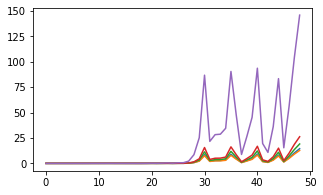

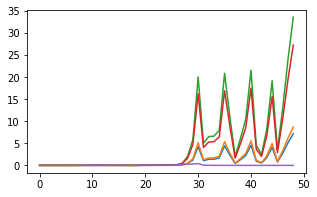

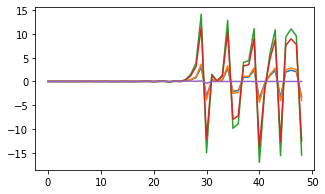

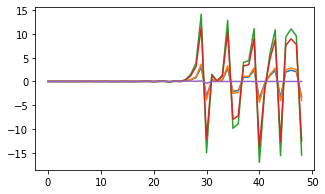

In [9]:
var_changes_L0_w, var_changes_L2_w, var_changes_L4_w, var_changes_L6_w, var_changes_L7_w = [], [], [], [], [] 
var_accumulate_L0_w, var_accumulate_L2_w, var_accumulate_L4_w, var_accumulate_L6_w, var_accumulate_L7_w = [], [], [], [], [] 

var_changes_L0_b, var_changes_L2_b, var_changes_L4_b, var_changes_L6_b, var_changes_L7_b = [], [], [], [], [] 
var_accumulate_L0_b, var_accumulate_L2_b, var_accumulate_L4_b, var_accumulate_L6_b, var_accumulate_L7_b = [], [], [], [], [] 


for global_epoch in range(G_epoch-2):
    for layer_index in num_layers_list:
        globals()['var_accumulate_L{}_w'.format(layer_index)].append(np.var(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)][0]))
        globals()['var_changes_L{}_w'.format(layer_index)].append(np.var(globals()['G{}_w_layer{}'.format(global_epoch+1, layer_index)][0]) - np.var(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)][0]))
        
        globals()['var_accumulate_L{}_b'.format(layer_index)].append(np.var(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)][1]))
        globals()['var_changes_L{}_b'.format(layer_index)].append(np.var(globals()['G{}_w_layer{}'.format(global_epoch+1, layer_index)][1]) - np.var(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)][1]))
        

print("Variance Accumulate Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------\n")

print("\nVar Accumulate Weight\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_accumulate_L{}_w'.format(j)])

print("\nVar Accumulate Bias\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_accumulate_L{}_b'.format(j)])

print("\n\nVariance Change Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------\n")

print("\nVar Changes Weight\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_changes_L{}_w'.format(j)])

print("\nVar Changes Bias\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_changes_L{}_b'.format(j)])



print("\nNow Check the graph\n")

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_accumulate_L{}_w'.format(j)])

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_accumulate_L{}_b'.format(j)])

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_changes_L{}_b'.format(j)])

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_changes_L{}_b'.format(j)])


Distance Layer 0,2,4,6,7
--------------------------------------------------------------------------------------------------
[0.00083609624, 0.0042557367, 0.0044105393, 0.0037889564, 0.0069746175, 0.020853722, 0.011006097, 0.015525933, 0.021066753, 0.0056021097, 0.0061062607, 0.00849665, 0.019368375, 0.0076698153, 0.008721499, 0.005089497, 0.017739478, 0.0049438896, 0.026587566, 0.04650926, 0.029342629, 0.040345397, 0.045599777, 0.06426179, 0.0813087, 0.013097773, 0.15503453, 0.33398512, 0.4839257, 0.9949782, 1.0789808, 0.1537143, 0.010356669, 0.12024997, 0.84214616, 0.60468644, 0.9117082, 0.500659, 0.37207195, 0.68275803, 1.218386, 0.2619694, 0.63037103, 0.72443926, 1.2087424, 0.827135, 0.63109756, 0.43365505, 0.7472089]
[0.00081874843, 0.0018938687, 0.0043082517, 0.0034506733, 0.0065543205, 0.016359407, 0.0121120075, 0.01855705, 0.020137591, 0.005956763, 0.006761702, 0.009506057, 0.017296994, 0.005205893, 0.008017215, 0.0033572312, 0.016649889, 0.006913696, 0.022163587, 0.047969434, 0

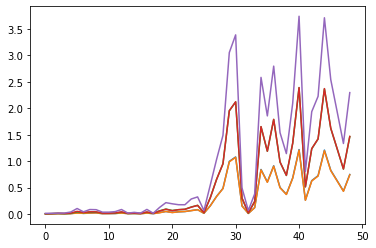

In [10]:
from scipy.spatial import distance

dist_0, dist_2, dist_4, dist_6, dist_7  = [], [], [], [], []

for global_epoch in range(G_epoch-2):
    for layer_index in num_layers_list:
        globals()['dist_{}'.format(layer_index)].append(np.mean(distance.euclidean(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)], globals()['G{}_w_layer{}'.format(global_epoch+1, layer_index)])))



print("Distance Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------")
print(dist_0)
print(dist_2)
print(dist_4)
print(dist_6)
print(dist_7, "\n\nCheck the graph\n")

plt.plot(dist_0)
plt.plot(dist_2)
plt.plot(dist_4)
plt.plot(dist_6)
plt.plot(dist_7)

plt.show()

Average Acc and Loss Layer 0,2,4,6,7
--------------------------------------------------------------------------------------------------
[[0.45798319578170776, 0.3907563090324402, 0.3340336084365845, 0.4495798349380493, 0.3382352888584137, 0.43697479367256165, 0.3340336084365845, 0.41806721687316895, 0.41806721687316895, 0.4432772994041443, 0.5, 0.43697479367256165, 0.42016807198524475, 0.3613445460796356, 0.3592436909675598, 0.462184876203537, 0.3424369692802429, 0.4159663915634155, 0.3172268867492676, 0.4327731132507324], [0.08193277567625046, 0.10084033757448196, 0.23529411852359772, 0.11554621905088425, 0.10294117778539658, 0.11764705926179886, 0.11764705926179886, 0.10294117778539658, 0.08403361588716507, 0.1071428582072258, 0.12184873968362808, 0.1071428582072258, 0.0882352963089943, 0.08403361588716507, 0.10294117778539658, 0.11974789947271347, 0.10924369841814041, 0.0903361365199089, 0.10084033757448196, 0.09453781694173813], [0.2310924381017685, 0.22268907725811005, 0.195378154

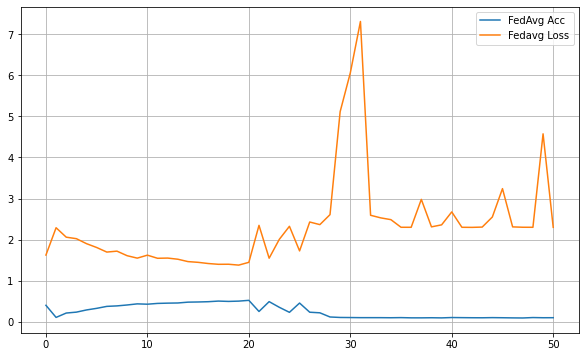

In [11]:
average_acc_list, average_loss_list = [], []


for i in range(len(FedAvg_ACC)):
    average_acc_list.append(np.mean(FedAvg_ACC[i]))
    average_loss_list.append(np.mean(FedAvg_LOSS[i]))
    

print("Average Acc and Loss Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------")
print(FedAvg_ACC)
print(FedAvg_LOSS)
print("\n\n Now Check the graph\n")

plt.figure(figsize=(10,6))
plt.plot(average_acc_list, label='FedAvg Acc')

plt.plot(average_loss_list, label='Fedavg Loss')

plt.grid(True)
plt.legend()
plt.show()
